<a href="https://colab.research.google.com/github/Evans2424/IACEC_Project_Model_Performance_Analysis/blob/main/IACEC_MLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis and Predictive Modeling for Liver Disease Diagnosis in Patients

In [160]:
!pip install openml
import openml

# List all datasets and their properties
openml.datasets.list_datasets(output_format="dataframe")

# Get dataset by ID
dataset = openml.datasets.get_dataset(1480)

# Get dataset by name
dataset = openml.datasets.get_dataset('ilpd')

# Get the data itself as a dataframe (or otherwise)
data, target, _, _ = dataset.get_data(dataset_format="dataframe")

## Data Preprocessing


In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set()
plt.style.use('ggplot')



liver_df = pd.DataFrame(data)

# Check the dataframe records and columns
print(liver_df.head())
print(liver_df.columns)

   V1      V2    V3   V4     V5    V6     V7   V8   V9   V10 Class
0  65  Female   0.7  0.1  187.0  16.0   18.0  6.8  3.3  0.90     1
1  62    Male  10.9  5.5  699.0  64.0  100.0  7.5  3.2  0.74     1
2  62    Male   7.3  4.1  490.0  60.0   68.0  7.0  3.3  0.89     1
3  58    Male   1.0  0.4  182.0  14.0   20.0  6.8  3.4  1.00     1
4  72    Male   3.9  2.0  195.0  27.0   59.0  7.3  2.4  0.40     1
Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'Class'], dtype='object')


In [162]:
# Rename the columns into meaningful names
new_column_names = {
    'V1': 'Age',
    'V2': 'Gender',
    'V3': 'Total Bilirubin',
    'V4': 'Direct Bilirubin',
    'V5': 'Phosphatase',
    'V6': 'Sgpt',
    'V7': 'Sgot',
    'V8': 'Total Proteins',
    'V9': 'Albumin',
    'V10': 'A/G Ratio'
}

# Rename the columns of the DataFrame
liver_df = liver_df.rename(columns=new_column_names)

# Print the first few rows to check the changes
liver_df.head()

,Age,Gender,Total Bilirubin,Direct Bilirubin,Phosphatase,Sgpt,Sgot,Total Proteins,Albumin,A/G Ratio,Class
0,65,Female,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1


In [163]:
liver_df['Class'] = liver_df['Class'].astype(int)
print(liver_df['Class'].unique())
liver_df['Class'].value_counts()

[1 2]


,count
Class,
1,416
2,167


In [164]:
# Describe the dataset
liver_df.describe()

,Age,Total Bilirubin,Direct Bilirubin,Phosphatase,Sgpt,Sgot,Total Proteins,Albumin,A/G Ratio,Class
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.318492,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.947064,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


In [165]:
# Information about the dataset
liver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               583 non-null    uint8   
 1   Gender            583 non-null    category
 2   Total Bilirubin   583 non-null    float64 
 3   Direct Bilirubin  583 non-null    float64 
 4   Phosphatase       583 non-null    float64 
 5   Sgpt              583 non-null    float64 
 6   Sgot              583 non-null    float64 
 7   Total Proteins    583 non-null    float64 
 8   Albumin           583 non-null    float64 
 9   A/G Ratio         583 non-null    float64 
 10  Class             583 non-null    int64   
dtypes: category(1), float64(8), int64(1), uint8(1)
memory usage: 42.4 KB


In [166]:
# Checking if there is null values or not
liver_df.isnull()

,Age,Gender,Total Bilirubin,Direct Bilirubin,Phosphatase,Sgpt,Sgot,Total Proteins,Albumin,A/G Ratio,Class
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
578,False,False,False,False,False,False,False,False,False,False,False
579,False,False,False,False,False,False,False,False,False,False,False
580,False,False,False,False,False,False,False,False,False,False,False
581,False,False,False,False,False,False,False,False,False,False,False


In [167]:
# Checking if there is null values or not
liver_df.isnull().sum()

,0
Age,0
Gender,0
Total Bilirubin,0
Direct Bilirubin,0
Phosphatase,0
Sgpt,0
Sgot,0
Total Proteins,0
Albumin,0
A/G Ratio,0


In [168]:
# Removing of duplicates
print(liver_df.shape)
liver_df_uni = liver_df.drop_duplicates()
liver_df_uni.shape

(583, 11)


(570, 11)

## Data exploration/visualization

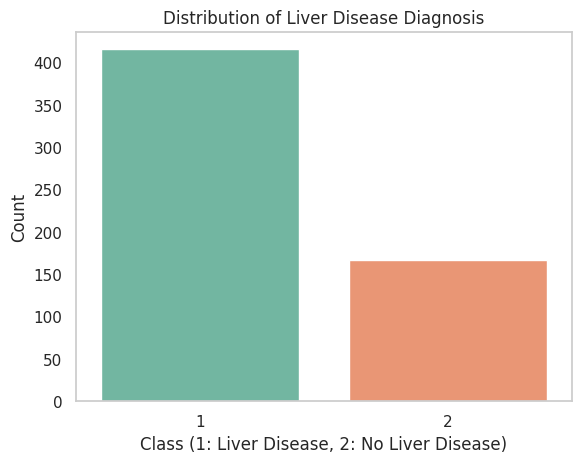

Number of patients diagnosed with liver disease:  416
Number of patients not diagnosed with liver disease:  167


In [172]:
sns.countplot(data=liver_df, x='Class', palette='Set2')
sns.set(style="whitegrid")
plt.title('Distribution of Liver Disease Diagnosis')
plt.xlabel('Class (1: Liver Disease, 2: No Liver Disease)')
plt.ylabel('Count')
plt.grid(False)
plt.show()

# Count the number of patients diagnosed with liver disease and those not diagnosed
LD, NLD = liver_df['Class'].value_counts()
print('Number of patients diagnosed with liver disease: ', LD)
print('Number of patients not diagnosed with liver disease: ', NLD)

Number of patients that are male:  441
Number of patients that are female:  142


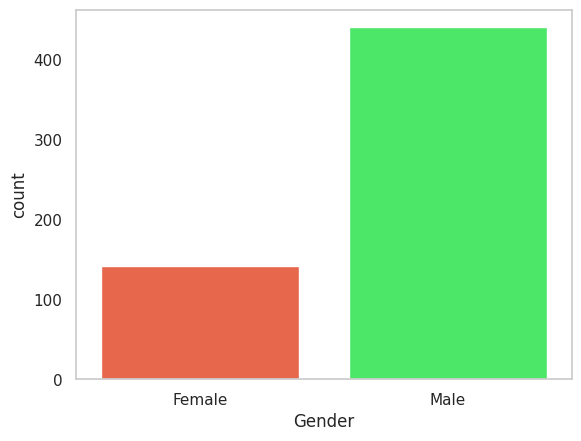

In [173]:
# Plotting the Number of Male and Female patients
sns.countplot(data=liver_df, x = 'Gender', label='Count',palette=["#FF5733", "#33FF57"])
sns.set(style="whitegrid")
plt.grid(False)


M, F = liver_df['Gender'].value_counts()
print('Number of patients that are male: ',M)
print('Number of patients that are female: ',F)

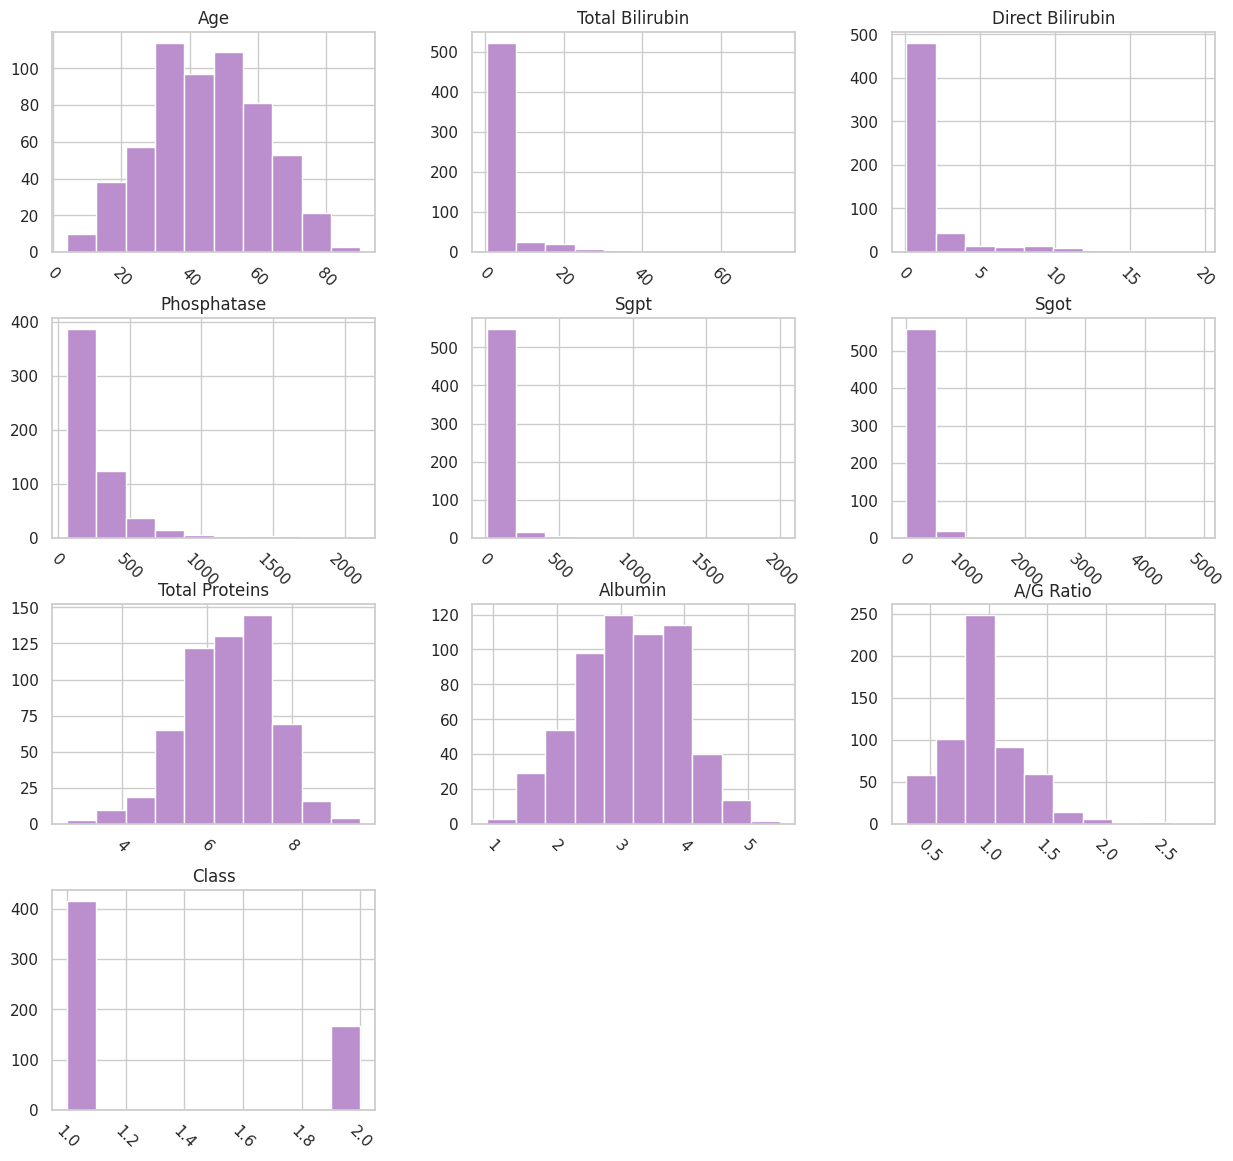

In [174]:
# Cheching for distribution

liver_df.hist(figsize=(15, 14), xrot=-45, bins=10, color='#BB8FCE')
plt.show()

In [187]:
# convert the gender to numeric values
print(liver_df['Gender'].unique())
liver_df1 = liver_df_uni.copy()
liver_df1['Gender'] = liver_df1['Gender'].astype(str)
def convertgender(x):
    if x == 'Male':
        return 0
    else:
        return 1
liver_df1['Gender'] = liver_df1['Gender'].map(convertgender)
liver_df1.head()

['Female', 'Male']
Categories (2, object): ['Female' < 'Male']


,Age,Gender,Total Bilirubin,Direct Bilirubin,Phosphatase,Sgpt,Sgot,Total Proteins,Albumin,A/G Ratio,Class
0,65,1,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62,0,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62,0,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58,0,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72,0,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1


In [188]:
liver_df1.corr()

#Positive correlations -> one feature increases other also increases
#Negative correlations -> one feature increases other descreases
#close to 0 -> weak relationship

,Age,Gender,Total Bilirubin,Direct Bilirubin,Phosphatase,Sgpt,Sgot,Total Proteins,Albumin,A/G Ratio,Class
Age,1.000000,-0.058237,0.011500,0.007050,0.081673,-0.083383,-0.016753,-0.197052,-0.271170,-0.215633,-0.138093
Gender,-0.058237,1.000000,-0.090298,-0.101730,0.023014,-0.084317,-0.081497,0.085895,0.091369,0.005566,0.078501
Total Bilirubin,0.011500,-0.090298,1.000000,0.874116,0.206239,0.217471,0.238678,-0.008588,-0.224124,-0.207621,-0.224430
Direct Bilirubin,0.007050,-0.101730,0.874116,1.000000,0.234609,0.237450,0.258489,-0.000875,-0.230751,-0.201386,-0.250666
Phosphatase,0.081673,0.023014,0.206239,0.234609,1.000000,0.126830,0.167230,-0.030048,-0.168318,-0.236028,-0.187560
Sgpt,-0.083383,-0.084317,0.217471,0.237450,0.126830,1.000000,0.791857,-0.035193,-0.027973,-0.006516,-0.161917
Sgot,-0.016753,-0.081497,0.238678,0.258489,0.167230,0.791857,1.000000,-0.022000,-0.085180,-0.072877,-0.151101
Total Proteins,-0.197052,0.085895,-0.008588,-0.000875,-0.030048,-0.035193,-0.022000,1.000000,0.784731,0.233576,0.037794
Albumin,-0.271170,0.091369,-0.224124,-0.230751,-0.168318,-0.027973,-0.085180,0.784731,1.000000,0.684087,0.166835
A/G Ratio,-0.215633,0.005566,-0.207621,-0.201386,-0.236028,-0.006516,-0.072877,0.233576,0.684087,1.000000,0.170523


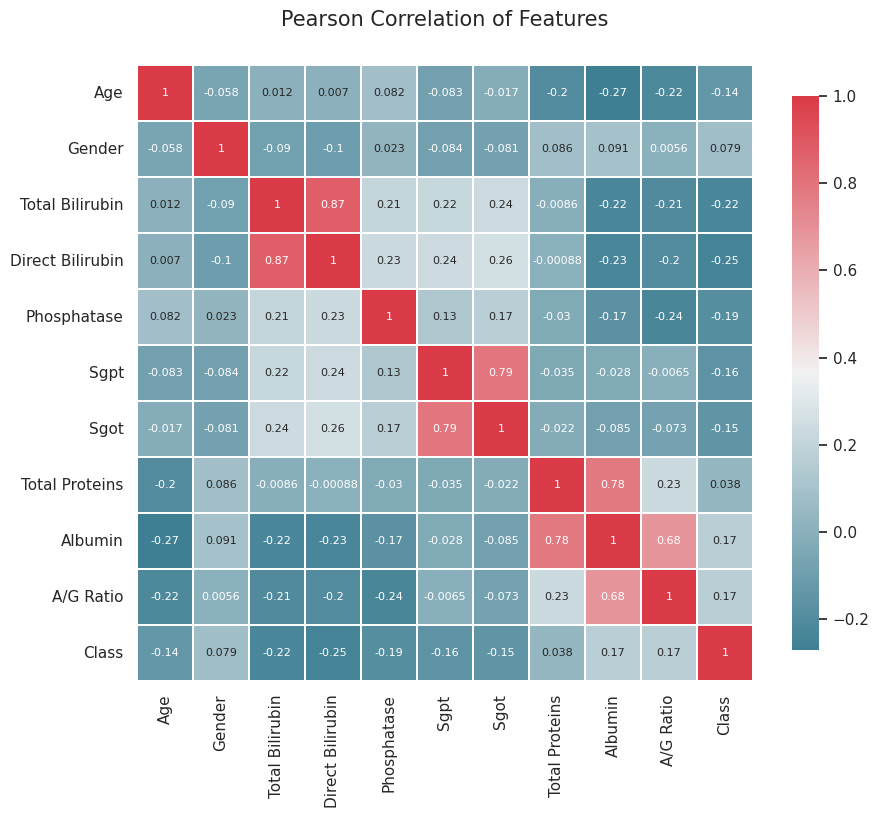

In [189]:
# Heatmap on correlation
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(10, 8))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)

    _ = sns.heatmap(
        liver_df1.corr(),
        cmap = colormap,
        square=True,
        cbar_kws={'shrink':.9 },
        ax=ax,
        annot=True,
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':8 }
    )

    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(liver_df1)

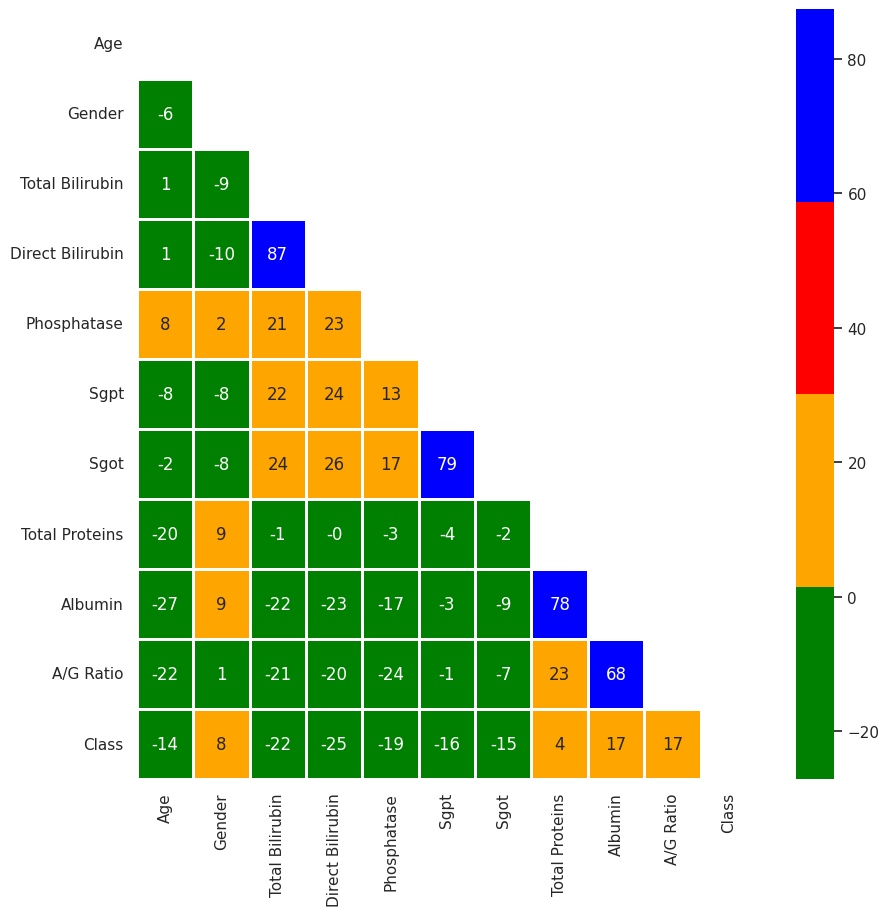

In [190]:
# triangular heatmaps
mask = np.triu(np.ones_like(liver_df1.corr()))
plt.figure(figsize=(10, 10))
with sns.axes_style('white'):
  ax= sns.heatmap(liver_df1.corr()*100, mask=mask, fmt=".0f", annot=True, lw =1,  cmap=ListedColormap(['green','orange','red','blue']))

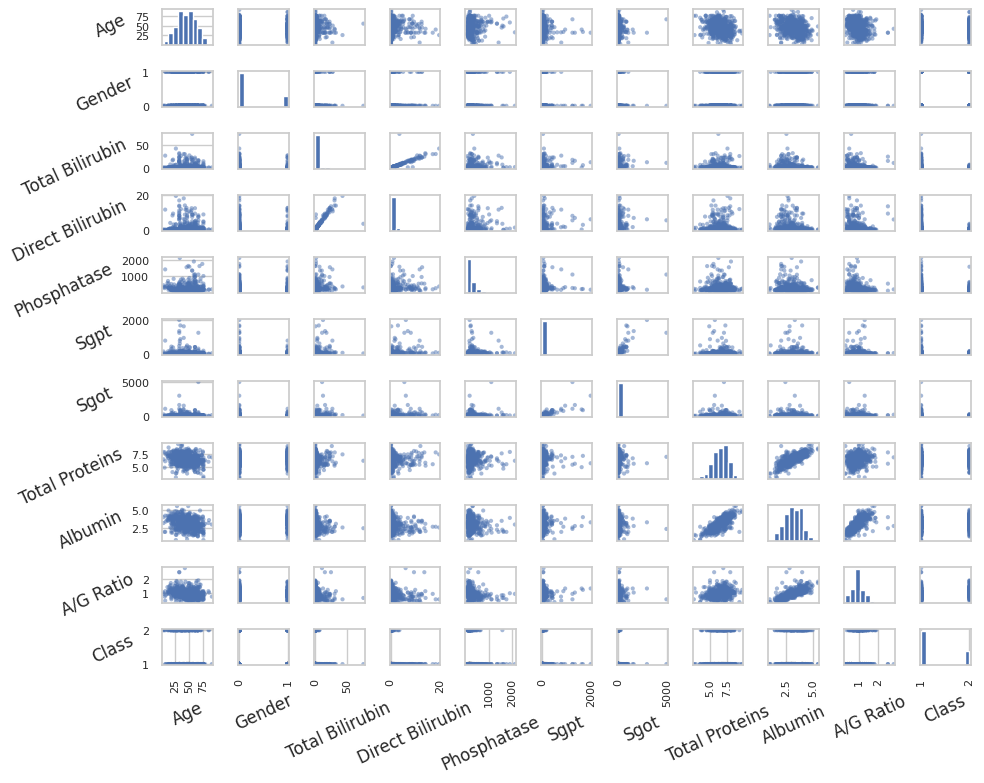

In [191]:
# Scatter plot matrix
axs = pd.plotting.scatter_matrix(liver_df1, figsize=(10, 8))
for ax in axs.flatten():
    ax.xaxis.label.set_rotation(25)
    ax.yaxis.label.set_rotation(25)
    ax.yaxis.label.set_ha('right')

# Adjust layout to prevent overlaps
plt.tight_layout()

plt.show()

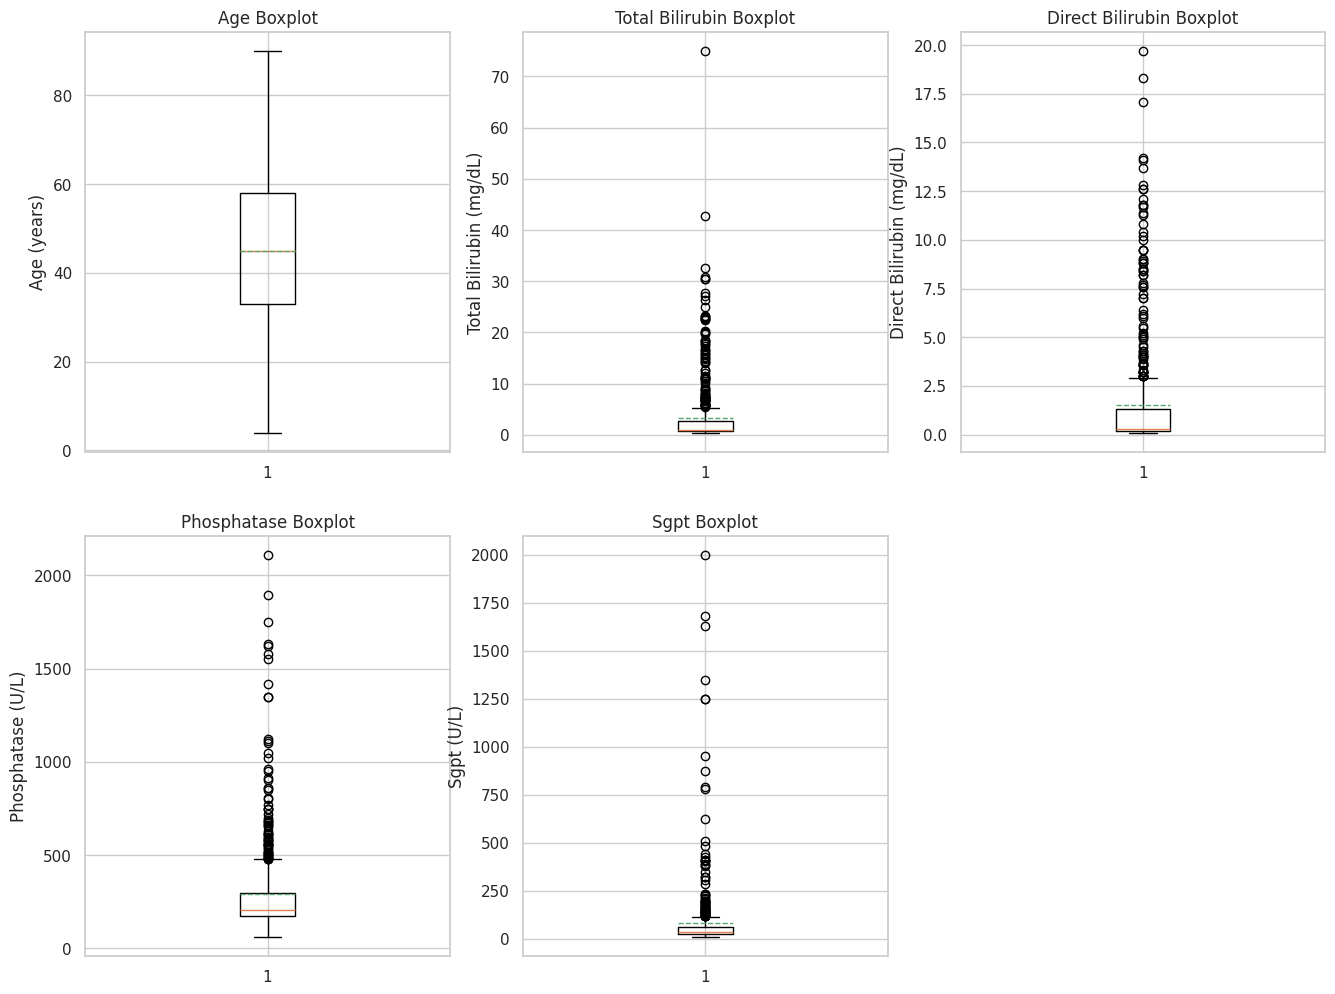

In [192]:
# Checking for outliers and deciding whether to keep them or remove
# Plotting the box plots
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x = liver_df1['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (years)')

plt.subplot(232)
plt.boxplot(liver_df1['Total Bilirubin'], showmeans = True, meanline = True)
plt.title('Total Bilirubin Boxplot')
plt.ylabel('Total Bilirubin (mg/dL)')

plt.subplot(233)
plt.boxplot(liver_df1['Direct Bilirubin'], showmeans = True, meanline = True)
plt.title('Direct Bilirubin Boxplot')
plt.ylabel('Direct Bilirubin (mg/dL)')

plt.subplot(234)
plt.boxplot(liver_df1['Phosphatase'], showmeans = True, meanline = True)
plt.title('Phosphatase Boxplot')
plt.ylabel('Phosphatase (U/L)')

plt.subplot(235)
plt.boxplot(liver_df1['Sgpt'], showmeans = True, meanline = True)
plt.title('Sgpt Boxplot')
plt.ylabel('Sgpt (U/L)')

plt.show()


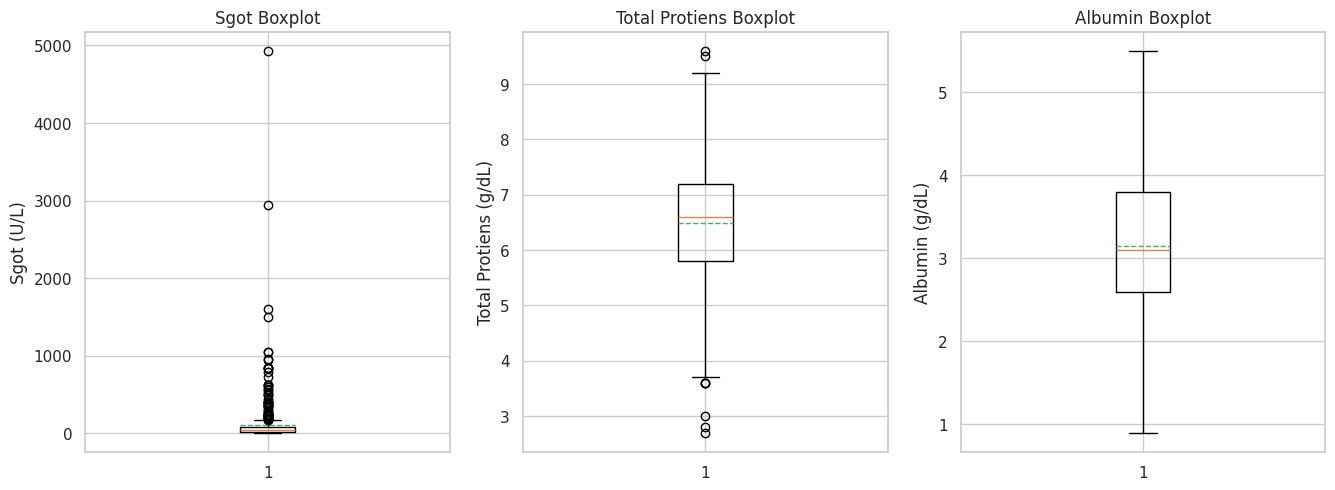

In [182]:
# bar plots for remaining features
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(liver_df1['Sgot'], showmeans = True, meanline = True)
plt.title('Sgot Boxplot')
plt.ylabel('Sgot (U/L)')

plt.subplot(232)
plt.boxplot(liver_df1['Total Proteins'], showmeans = True, meanline = True)
plt.title('Total Protiens Boxplot')
plt.ylabel('Total Protiens (g/dL)')

plt.subplot(233)
plt.boxplot(liver_df1['Albumin'], showmeans = True, meanline = True)
plt.title('Albumin Boxplot')
plt.ylabel('Albumin (g/dL)')

plt.show()

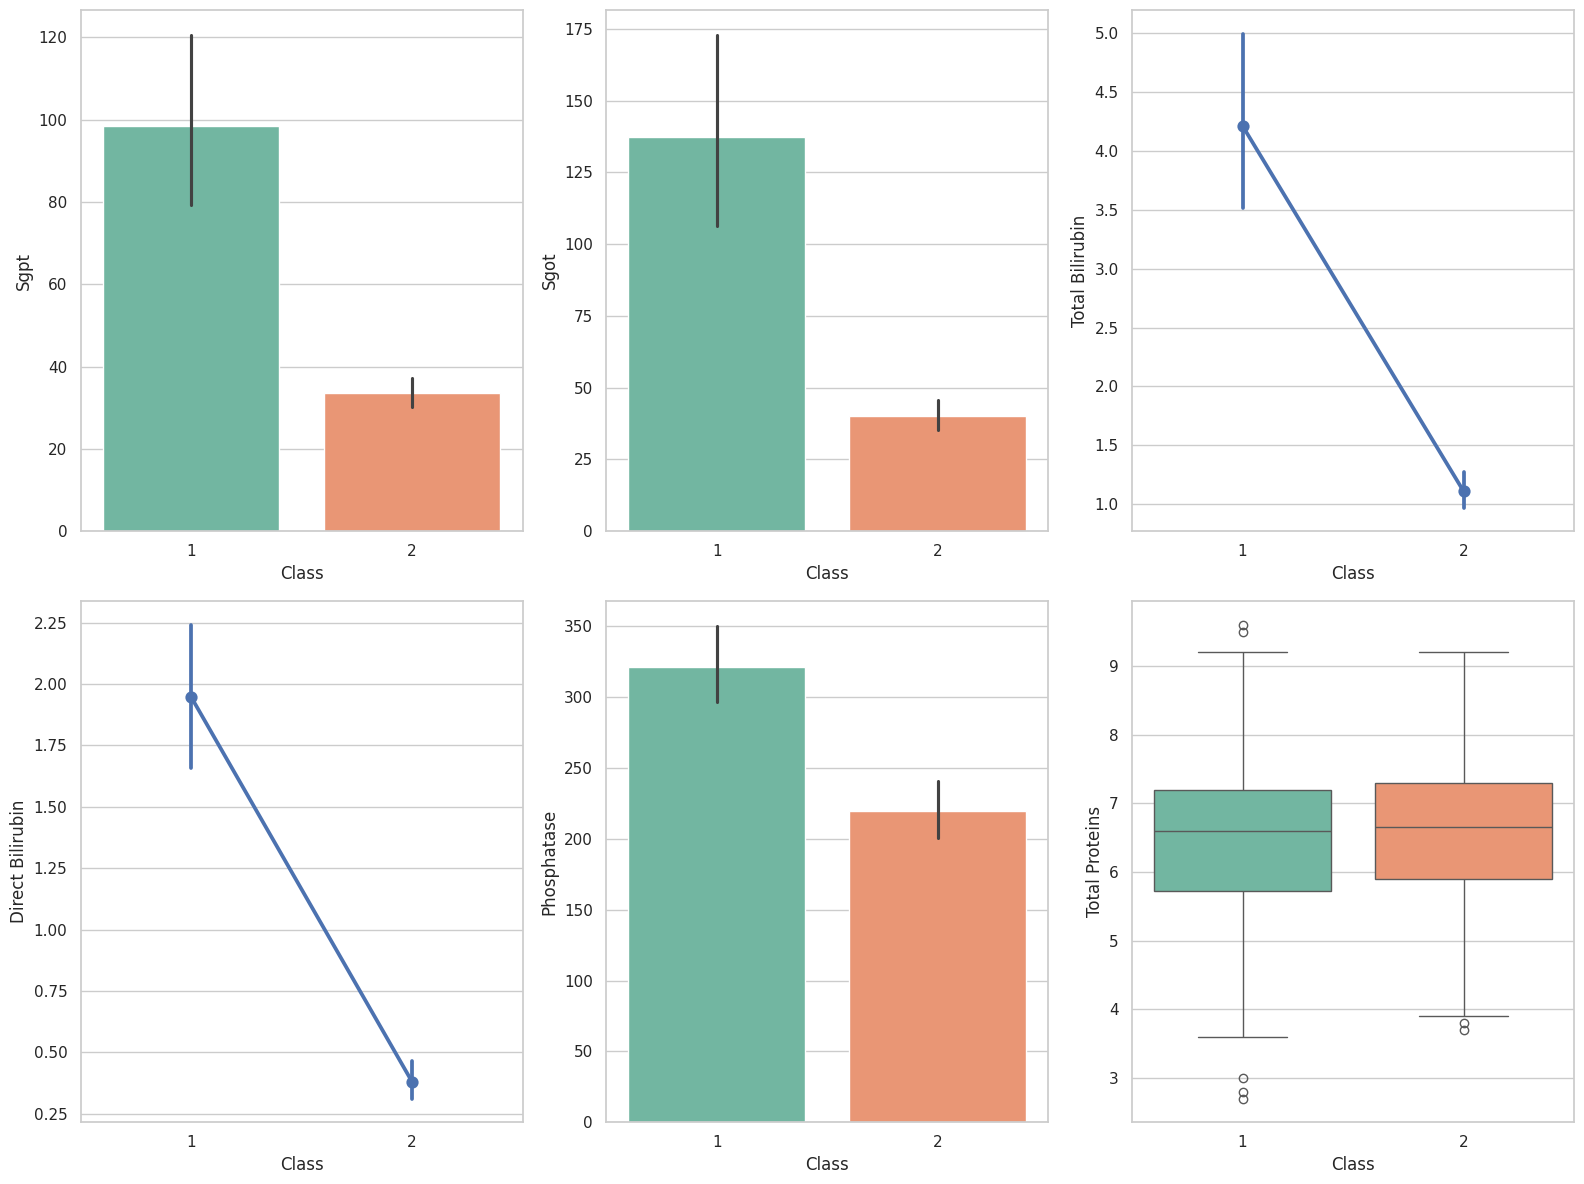

In [183]:
# Checking the whether those outliers are erraneous or
fig, saxis = plt.subplots(2, 3, figsize=(16, 12))
palette = sns.color_palette("Set2")

# Adjusting each plot for a unique axis in the grid
sns.barplot(y='Sgpt', x='Class', data=liver_df1, ax=saxis[0, 0], palette = palette)
sns.barplot(y='Sgot', x='Class', data=liver_df1, ax=saxis[0, 1], palette = palette)
sns.pointplot(y='Total Bilirubin', x='Class', data=liver_df1, ax=saxis[0, 2])
sns.pointplot(y='Direct Bilirubin', x='Class', data=liver_df1, ax=saxis[1, 0])
sns.barplot(y='Phosphatase', x='Class', data=liver_df1, ax=saxis[1, 1], palette = palette)
sns.boxplot(y = 'Total Proteins', x = 'Class', data=liver_df1, ax = saxis[1,2],palette = palette)

# Adjusting layout to prevent overlap
plt.tight_layout()
plt.show()

<Axes: xlabel='A/G Ratio', ylabel='Total Proteins'>

<Figure size 600x400 with 0 Axes>

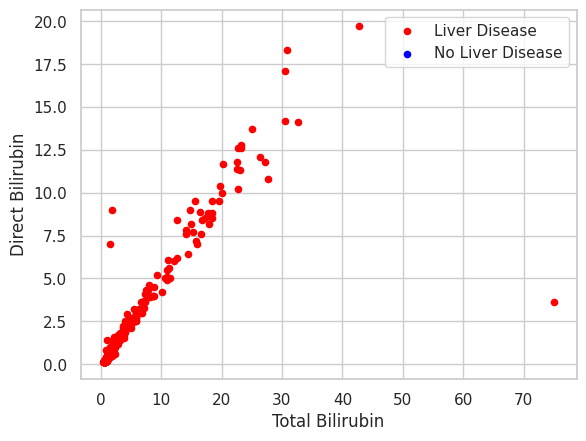

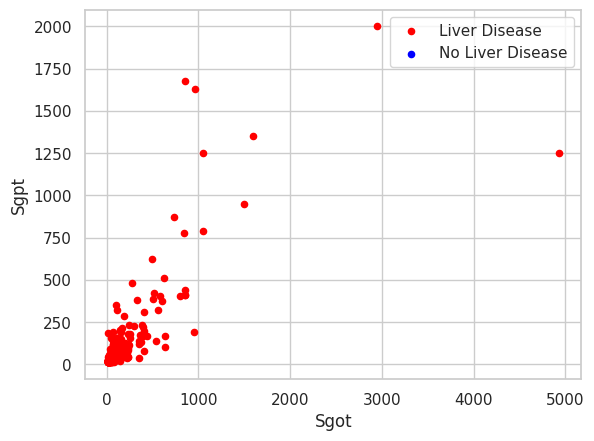

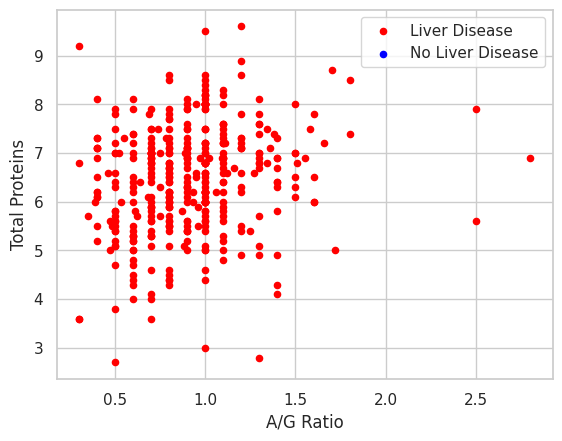

In [193]:
# Scatter plot to check linearity of data on few features
plt.figure(figsize=[6,4])
Liver_disease_df = liver_df1[liver_df1['Class'] == 1]
Not_Liver_disease_df = liver_df1[liver_df1['Class'] == 0]

axes = Liver_disease_df.plot(kind='scatter', x='Total Bilirubin', y='Direct Bilirubin', color='red', label='Liver Disease')
Not_Liver_disease_df.plot(kind='scatter', x='Total Bilirubin', y='Direct Bilirubin', color='blue', label='No Liver Disease',ax=axes)

axes = Liver_disease_df.plot(kind='scatter', x='Sgot', y='Sgpt', color='red', label='Liver Disease')
Not_Liver_disease_df.plot(kind='scatter', x='Sgot', y='Sgpt', color='blue', label='No Liver Disease',ax=axes)

axes = Liver_disease_df.plot(kind='scatter', x='A/G Ratio', y='Total Proteins', color='red', label='Liver Disease')
Not_Liver_disease_df.plot(kind='scatter', x='A/G Ratio', y='Total Proteins', color='blue', label='No Liver Disease',ax=axes)


<Figure size 1000x800 with 0 Axes>

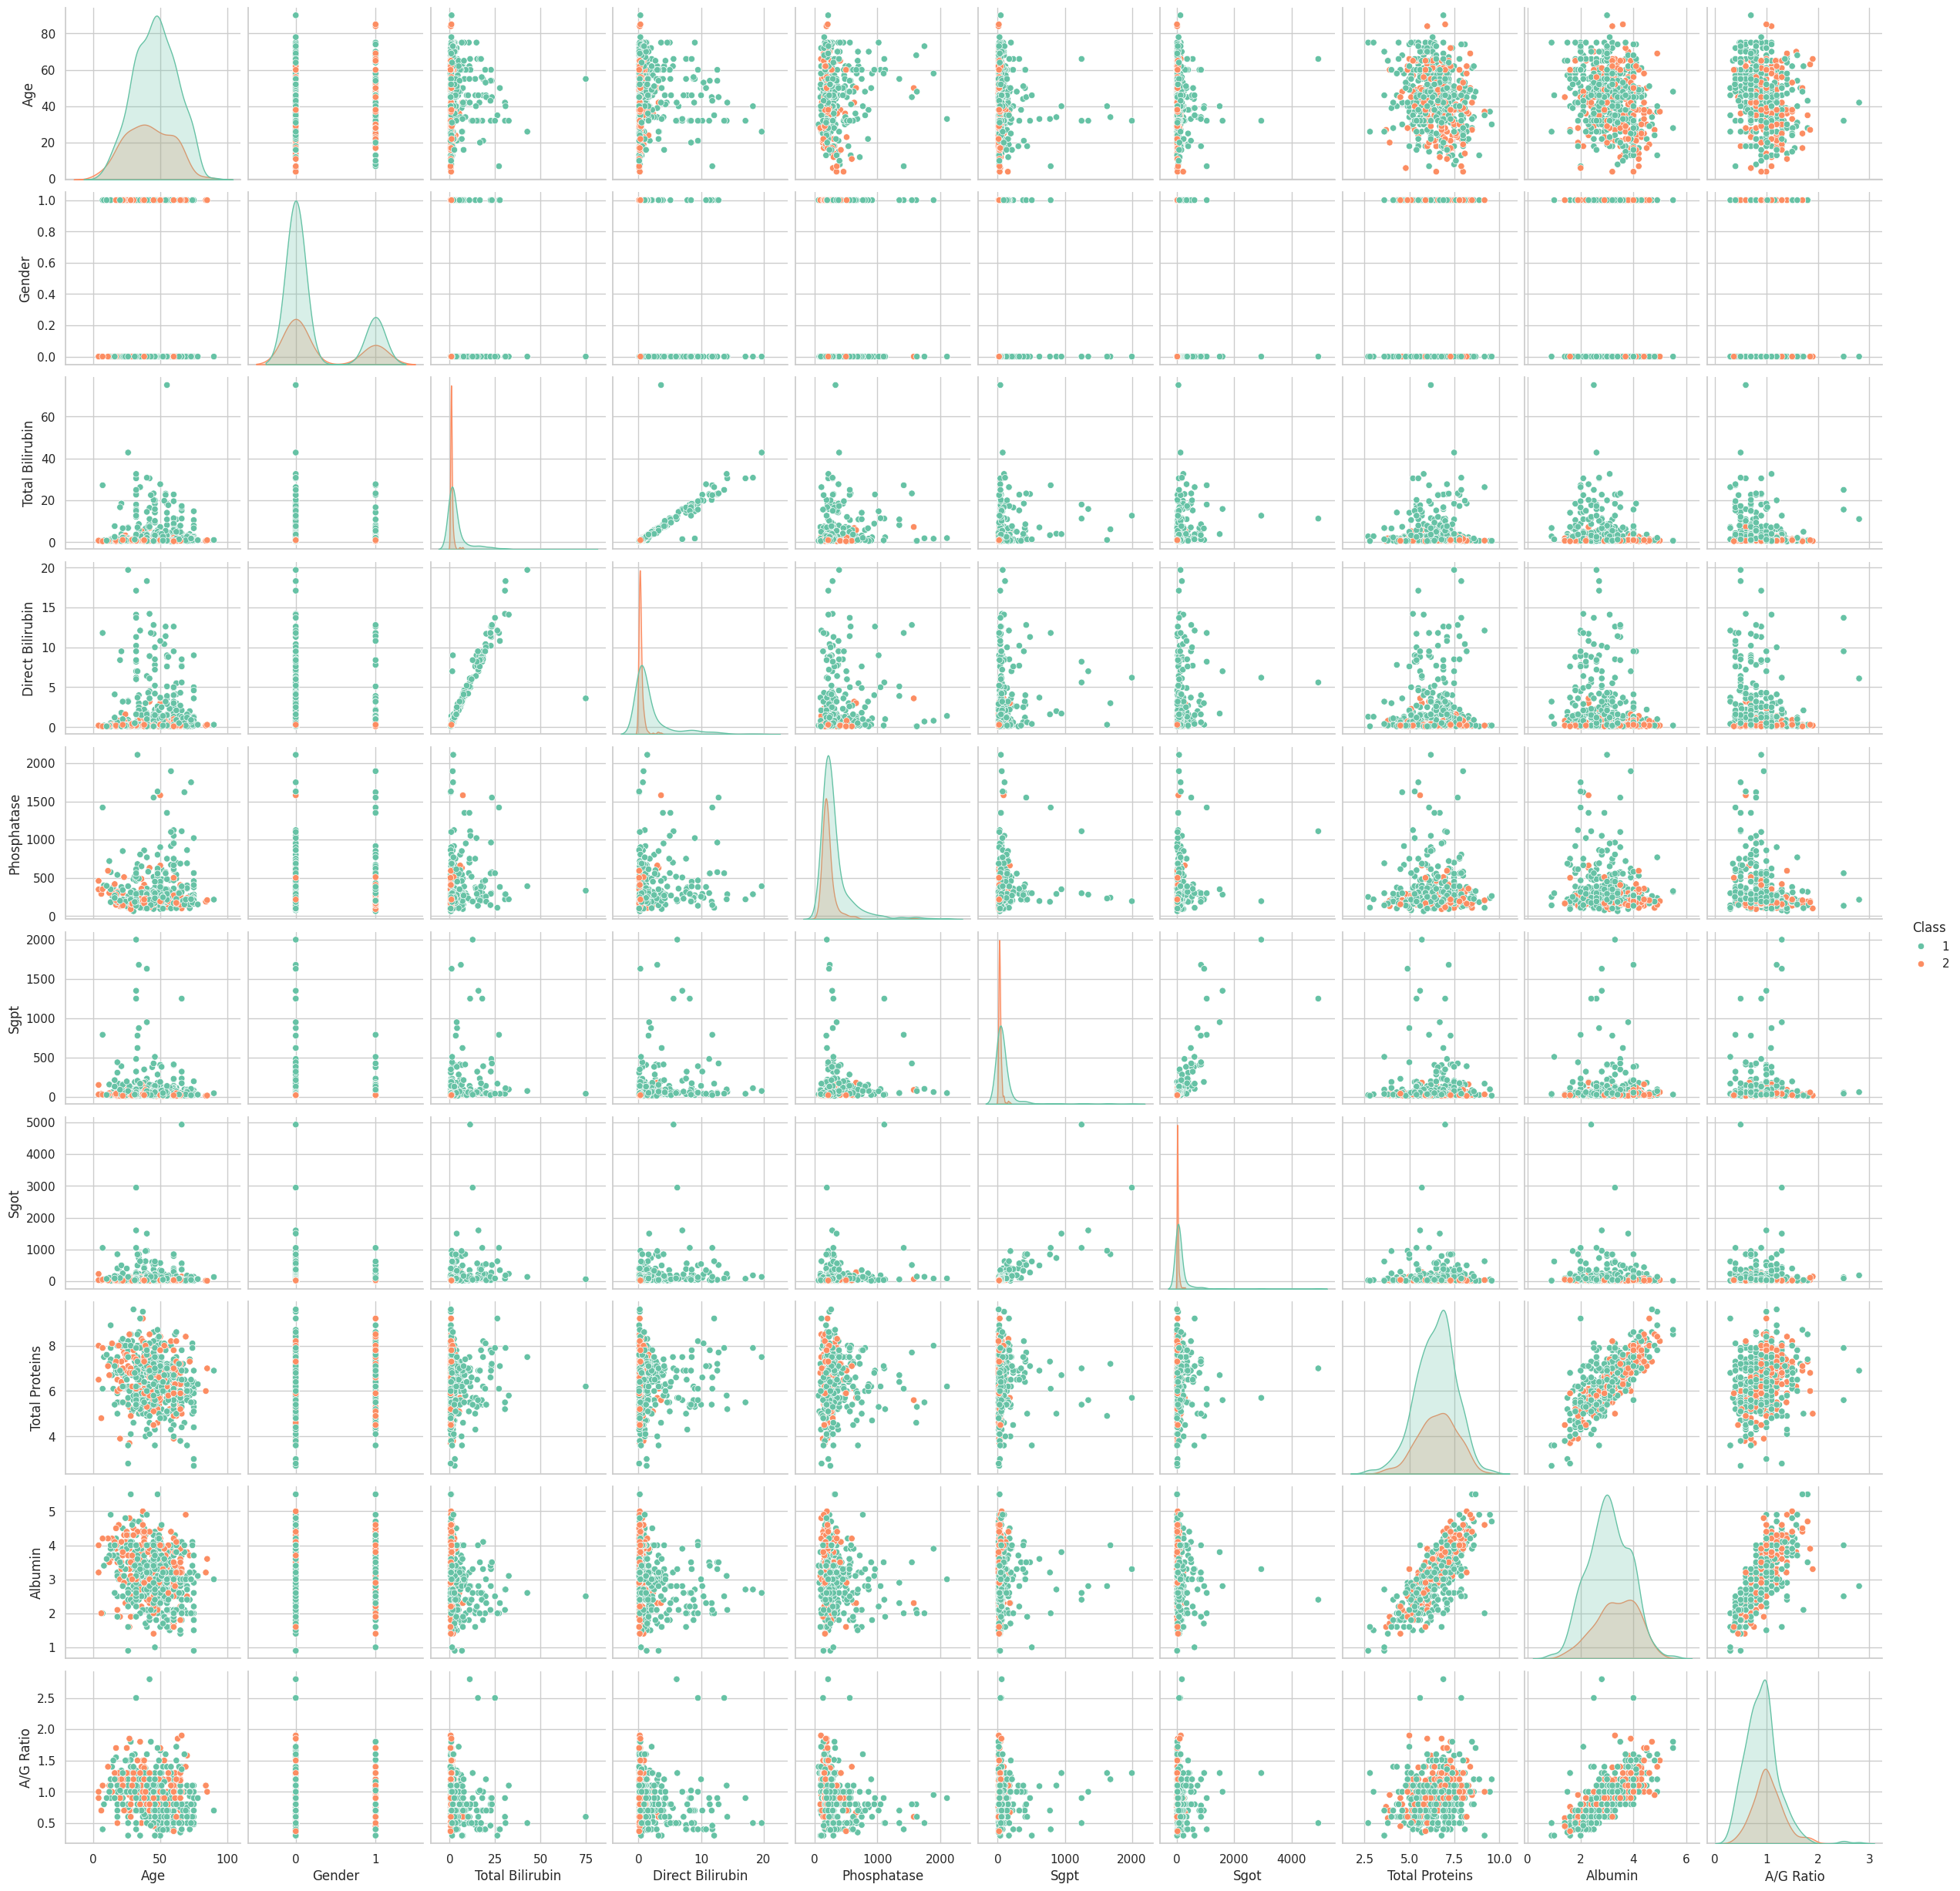

In [195]:
# Checking linearity of data on all features with pairplot
plt.figure(figsize=(10, 8))
sns.pairplot(liver_df1, hue='Class', diag_kind='kde', palette='Set2')

# Save the figure with higher DPI for a clearer image
plt.savefig("pairplot_liver_disease.png", dpi=300, bbox_inches='tight')
plt.show()

## Prepare the Data for model and predictions

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

X = liver_df1.drop(columns=['Class'])
y = liver_df1['Class']

# Divide the dataset to test and train datasets
X_train, X_test, y_train , y_test = train_test_split(X,y, test_size=0.2, random_state=0, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(456, 10)
(114, 10)
(456,)
(114,)


In [102]:
# Feature Scaling both test and train dataset using standardization
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
print(X_train.describe())

X_test = (X_test - train_mean) / train_std
print(X_test.describe())

                Age        Gender  Total Bilirubin  Direct Bilirubin  \
count  4.560000e+02  4.560000e+02     4.560000e+02      4.560000e+02   
mean   2.532088e-17  1.752984e-17    -3.019028e-17      1.090745e-16   
std    1.000000e+00  1.000000e+00     1.000000e+00      1.000000e+00   
min   -2.532957e+00 -5.767169e-01    -4.501694e-01     -4.787689e-01   
25%   -7.568382e-01 -5.767169e-01    -3.883156e-01     -4.440048e-01   
50%    3.935290e-02 -5.767169e-01    -3.573887e-01     -4.092407e-01   
75%    8.049213e-01  0.000000e+00    -1.099736e-01     -9.636367e-02   
max    2.427926e+00  1.730151e+00     1.108556e+01      6.334997e+00   

        Phosphatase          Sgpt          Sgot  Total Proteins       Albumin  \
count  4.560000e+02  4.560000e+02  4.560000e+02    4.560000e+02  4.560000e+02   
mean  -4.674623e-17  4.187683e-17  7.791039e-18   -2.181491e-16  4.655146e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00  1.000000e+00   
min   -8.541351e-01 -3.8680

### The below code shows how imbalanced data can effect the model

accuracy_score: 0.7105263157894737
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.71      1.00      0.83        81

    accuracy                           0.71       114
   macro avg       0.36      0.50      0.42       114
weighted avg       0.50      0.71      0.59       114



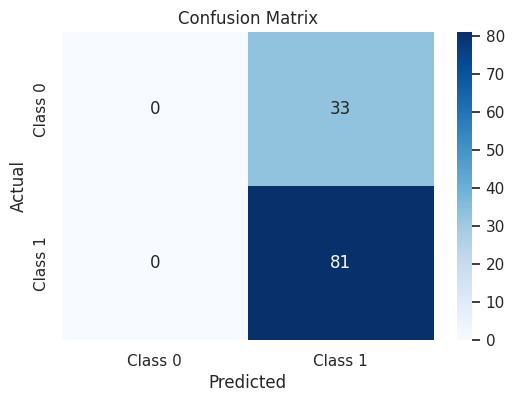

AUC: 0.6550692106247662


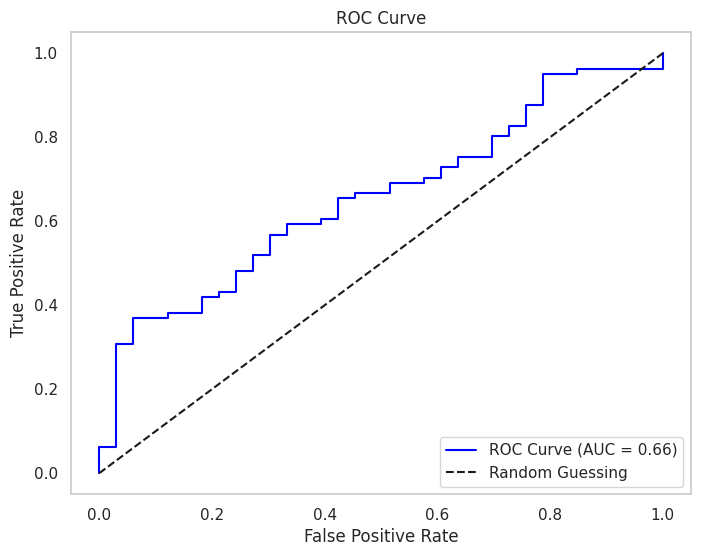

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score, roc_curve
from sklearn.svm import SVC

X = liver_df1.drop(columns=['Class'])
y = liver_df1['Class']

X_train, X_test, y_train , y_test = train_test_split(X,y, test_size=0.2, random_state=0, stratify=y)

classifier = SVC(probability=True)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("accuracy_score:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# AUC and ROC curve
y_prob = classifier.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print("AUC:", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [136]:
print(y_test.value_counts())
print(y_pred)

Class
1    81
0    33
Name: count, dtype: int64
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


## Handling Imabalnced Data using class weight, oversampling, undersampling and Ensemble Techniques

In [104]:
from sklearn import metrics
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

def model_ensemble_resampling_pipeline(X_train, X_test, y_train, y_test, model):
    results = {
        'class_weight': {},
        'oversample': {},
        'undersample': {},
        'ensemble': {}
    }

    # Class weight
    if 'class_weight' in model.get_params().keys():
        model.set_params(class_weight='balanced')
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        results['class_weight'] = {
            'accuracy': accuracy, 'precision': precision, 'recall': recall,
            'fscore': fscore, 'n_occurences': support,
            'predictions_count': Counter(predictions),
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
            'auc': auc
        }
        print("Results with Class Weight ('balanced'):")
        for key, value in results['class_weight'].items():
            print(f"{key}: {value}")
        print(classification_report(y_test, predictions))

    # Oversampling techniques
    oversampling_techniques = [RandomOverSampler(), SMOTE(), ADASYN()]
    for sampler in oversampling_techniques:
        technique = sampler.__class__.__name__
        print(f'Technique: {technique}')
        print(f'Before resampling: {sorted(Counter(y_train).items())}')
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        print(f'After resampling: {sorted(Counter(y_resampled).items())}')

        model.fit(X_resampled, y_resampled)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        results['oversample'][technique] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'fscore': fscore,
            'n_occurences': support,
            'predictions_count': Counter(predictions),
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
            'auc': auc
        }
        print(f"Results with oversampling ({technique}):")
        for key, value in results['oversample'][technique].items():
            print(f"{key}: {value}")
        print(classification_report(y_test, predictions))

    # Undersampling techniques
    undersampling_techniques = [RandomUnderSampler()]
    for sampler in undersampling_techniques:
        technique = sampler.__class__.__name__
        print(f'Technique: {technique}')
        print(f'Before resampling: {sorted(Counter(y_train).items())}')
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        print(f'After resampling: {sorted(Counter(y_resampled).items())}')

        model.fit(X_resampled, y_resampled)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        results['undersample'][technique] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'fscore': fscore,
            'n_occurences': support,
            'predictions_count': Counter(predictions),
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
            'auc': auc
        }
        print(f"Results with undersampling ({technique}):")
        for key, value in results['undersample'][technique].items():
            print(f"{key}: {value}")
        print(classification_report(y_test, predictions))

    # Ensemble techniques
    ensemble_techniques = [
        ('BalancedBagging', BalancedBaggingClassifier()),
        ('EasyEnsemble', EasyEnsembleClassifier()),
        ('GradientBoosting', GradientBoostingClassifier())
    ]

    for name, boosting_model in ensemble_techniques:
        print(f'ensemble Technique: {name}')
        boosting_model.fit(X_train, y_train)
        predictions = boosting_model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        results['ensemble'][name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'fscore': fscore,
            'n_occurences': support,
            'predictions_count': Counter(predictions),
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
            'auc': auc
        }
        print(f"Results with ensemble ({name}):")
        for key, value in results['ensemble'][name].items():
            print(f"{key}: {value}")
        print(classification_report(y_test, predictions))

    return results


### finding the c and gamma values

In [118]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

model = SVC()

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 0.05, 10],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=5,
                           verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and results
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation AUC:", best_score)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'C': 0.05, 'gamma': 0.0001}
Best Cross-Validation AUC: 0.6523559062020601


### SVC with linear kernel

In [119]:
model = SVC(kernel = 'linear', random_state = 0)
results = model_ensemble_resampling_pipeline(X_train, X_test, y_train, y_test, model)

Results with Class Weight ('balanced'):
accuracy: 0.631578947368421
precision: [0.43283582 0.91489362]
recall: [0.87878788 0.5308642 ]
fscore: [0.58     0.671875]
n_occurences: [33 81]
predictions_count: Counter({0: 67, 1: 47})
tp: 43
tn: 29
fp: 4
fn: 38
auc: 0.7048260381593715
              precision    recall  f1-score   support

           0       0.43      0.88      0.58        33
           1       0.91      0.53      0.67        81

    accuracy                           0.63       114
   macro avg       0.67      0.70      0.63       114
weighted avg       0.78      0.63      0.65       114

Technique: RandomOverSampler
Before resampling: [(0, 131), (1, 325)]
After resampling: [(0, 325), (1, 325)]
Results with oversampling (RandomOverSampler):
accuracy: 0.6140350877192983
precision: [0.42028986 0.91111111]
recall: [0.87878788 0.50617284]
fscore: [0.56862745 0.65079365]
n_occurences: [33 81]
predictions_count: Counter({0: 69, 1: 45})
tp: 41
tn: 29
fp: 4
fn: 40
auc: 0.692480359147

### SVC with linear kernel and C = 0.05

In [131]:
model = SVC(kernel = 'linear', C = 0.05, random_state = 0)
results = model_ensemble_resampling_pipeline(X_train, X_test, y_train, y_test, model)

Results with Class Weight ('balanced'):
accuracy: 0.6491228070175439
precision: [0.44615385 0.91836735]
recall: [0.87878788 0.55555556]
fscore: [0.59183673 0.69230769]
n_occurences: [33 81]
predictions_count: Counter({0: 65, 1: 49})
tp: 45
tn: 29
fp: 4
fn: 36
auc: 0.7171717171717171
              precision    recall  f1-score   support

           0       0.45      0.88      0.59        33
           1       0.92      0.56      0.69        81

    accuracy                           0.65       114
   macro avg       0.68      0.72      0.64       114
weighted avg       0.78      0.65      0.66       114

Technique: RandomOverSampler
Before resampling: [(0, 131), (1, 325)]
After resampling: [(0, 325), (1, 325)]
Results with oversampling (RandomOverSampler):
accuracy: 0.631578947368421
precision: [0.43283582 0.91489362]
recall: [0.87878788 0.5308642 ]
fscore: [0.58     0.671875]
n_occurences: [33 81]
predictions_count: Counter({0: 67, 1: 47})
tp: 43
tn: 29
fp: 4
fn: 38
auc: 0.704826038159

### SVC with polynomial kernel and degree = 4

In [120]:
model = SVC(kernel = 'poly', degree = 4)
results = model_ensemble_resampling_pipeline(X_train, X_test, y_train, y_test, model)

Results with Class Weight ('balanced'):
accuracy: 0.42105263157894735
precision: [0.32258065 0.85714286]
recall: [0.90909091 0.22222222]
fscore: [0.47619048 0.35294118]
n_occurences: [33 81]
predictions_count: Counter({0: 93, 1: 21})
tp: 18
tn: 30
fp: 3
fn: 63
auc: 0.5656565656565656
              precision    recall  f1-score   support

           0       0.32      0.91      0.48        33
           1       0.86      0.22      0.35        81

    accuracy                           0.42       114
   macro avg       0.59      0.57      0.41       114
weighted avg       0.70      0.42      0.39       114

Technique: RandomOverSampler
Before resampling: [(0, 131), (1, 325)]
After resampling: [(0, 325), (1, 325)]
Results with oversampling (RandomOverSampler):
accuracy: 0.4298245614035088
precision: [0.32608696 0.86363636]
recall: [0.90909091 0.2345679 ]
fscore: [0.48       0.36893204]
n_occurences: [33 81]
predictions_count: Counter({0: 92, 1: 22})
tp: 19
tn: 30
fp: 3
fn: 62
auc: 0.571829

### SVC with rbf kernel and C = 0.05, gamma = 0.0001

In [124]:
model = SVC(kernel = 'rbf', C = 0.05, gamma = 0.0001, random_state = 0)
results = model_ensemble_resampling_pipeline(X_train, X_test, y_train, y_test, model)

Results with Class Weight ('balanced'):
accuracy: 0.6228070175438597
precision: [0.41071429 0.82758621]
recall: [0.6969697  0.59259259]
fscore: [0.51685393 0.69064748]
n_occurences: [33 81]
predictions_count: Counter({1: 58, 0: 56})
tp: 48
tn: 23
fp: 10
fn: 33
auc: 0.6447811447811448
              precision    recall  f1-score   support

           0       0.41      0.70      0.52        33
           1       0.83      0.59      0.69        81

    accuracy                           0.62       114
   macro avg       0.62      0.64      0.60       114
weighted avg       0.71      0.62      0.64       114

Technique: RandomOverSampler
Before resampling: [(0, 131), (1, 325)]
After resampling: [(0, 325), (1, 325)]
Results with oversampling (RandomOverSampler):
accuracy: 0.631578947368421
precision: [0.41818182 0.83050847]
recall: [0.6969697  0.60493827]
fscore: [0.52272727 0.7       ]
n_occurences: [33 81]
predictions_count: Counter({1: 59, 0: 55})
tp: 49
tn: 23
fp: 10
fn: 32
auc: 0.650953

### SVC with kernel rbf and no hyperparameter

In [122]:
model = SVC(kernel = 'rbf', random_state = 0)
results = model_ensemble_resampling_pipeline(X_train, X_test, y_train, y_test, model)

Results with Class Weight ('balanced'):
accuracy: 0.5877192982456141
precision: [0.39705882 0.86956522]
recall: [0.81818182 0.49382716]
fscore: [0.53465347 0.62992126]
n_occurences: [33 81]
predictions_count: Counter({0: 68, 1: 46})
tp: 40
tn: 27
fp: 6
fn: 41
auc: 0.6560044893378226
              precision    recall  f1-score   support

           0       0.40      0.82      0.53        33
           1       0.87      0.49      0.63        81

    accuracy                           0.59       114
   macro avg       0.63      0.66      0.58       114
weighted avg       0.73      0.59      0.60       114

Technique: RandomOverSampler
Before resampling: [(0, 131), (1, 325)]
After resampling: [(0, 325), (1, 325)]
Results with oversampling (RandomOverSampler):
accuracy: 0.5877192982456141
precision: [0.390625 0.84    ]
recall: [0.75757576 0.51851852]
fscore: [0.51546392 0.64122137]
n_occurences: [33 81]
predictions_count: Counter({0: 64, 1: 50})
tp: 42
tn: 25
fp: 8
fn: 39
auc: 0.63804713804